In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
import time

In [2]:
#maximum number of gaussians
#learning rate
#Initial weight of a gaussian
#Initial Variance of a gaussian
DataSet="Candela_m1.10"
PathFolder="Datasets/"+DataSet+"/"+DataSet+"/input/"
Result="Results/"+DataSet+"/"

maxGaussians=5
lr=0.001
initWeight=0.001
initVar=400
Th=0.9
C=3
sigma_threshold=6.5

In [2]:
#(PerPixelCalculation(np.array([122,122,122,1.0, 1.0,0.0,0.0,0.0,0.0, 1.0,0.0,0.0,0.0,0.0, 400.0,0.0,0.0,0.0,0.0, 125.0,125.0,125.0, 0.0,0.0,0.0 ,0.0,0.0,0.0 ,0.0,0.0,0.0 ,0.0,0.0,0.0, 1.0])))

In [3]:
def PerPixelCalculation(data):
    data=data.reshape(-1)
    pixel=data[:C]   #pixel data
    n_gaussians=data[C] # No of gaussians fitted for the pixel till now
    n_elements=data[C+1:C+1+maxGaussians] #No of elements (Pixels) in each gaussian till now
    weights=data[C+1+maxGaussians:C+1+2*maxGaussians] #weights of each gaussian distribution
    variance=data[C+1+2*maxGaussians:C+1+3*maxGaussians] #variance for each gaussian dist ribution
    mean=data[C+1+3*maxGaussians:C+1+3*maxGaussians+C*maxGaussians] #mean of each gaussian for each channel
    isGaussianFit=False

    for i in range(int(n_gaussians)):
        dis_from_mean= np.dot(pixel-mean[i*C:i*C+C],pixel-mean[i*C:i*C+C])
        if dis_from_mean < sigma_threshold*variance[i]:
            isGaussianFit=True
            weights[i] = (1-lr)*weights[i]+lr*1
            variance[i] = n_elements[i]*(variance[i] + (dis_from_mean/(n_elements[i]+1)))/(n_elements[i]+1)
            mean[i*C:i*C+C]=(mean[i*C:i*C+C]*n_elements[i]+pixel)/(n_elements[i]+1)
            n_elements[i]+=1
        else:
            weights[i] = (1-lr)*weights[i]
          
    if not isGaussianFit:
        if n_gaussians < maxGaussians:
            mean[int(n_gaussians*C):int(n_gaussians*C+C)]=pixel
            variance[int(n_gaussians)]=initVar
            weights[int(n_gaussians)]=initWeight 
            n_elements[int(n_gaussians)]=n_elements[int(n_gaussians)]+1
            n_gaussians+=1
        else:
            index=np.argmin(weights/variance)
            mean[index*C:index*C+C]=pixel
            variance[index]=initVar
            weights[index]=initWeight
            n_elements[index]=1

    weights=weights/(np.sum(weights))
    sum_weight=0
    output_mask=255.0
    indexes=np.argsort(weights[0:int(n_gaussians)]/variance[0:int(n_gaussians)])[::-1]

    for i in indexes:
        dis_from_mean= np.dot(pixel-mean[i:i+C],pixel-mean[i:i+C])
        if dis_from_mean < sigma_threshold*variance[i]:
            pixel[:]=255*np.ones(C)
            output_mask=0.0
            break
        sum_weight+=weights[i]
        if sum_weight>Th:
            break
    data[:C]=pixel
    data[C]=n_gaussians 
    data[C+1:C+1+maxGaussians]=n_elements 
    data[C+1+maxGaussians:C+1+2*maxGaussians] =weights
    data[C+1+2*maxGaussians:C+1+3*maxGaussians] =variance
    data[C+1+3*maxGaussians:C+1+3*maxGaussians+C*maxGaussians]=mean
    data[C+1+3*maxGaussians+C*maxGaussians]=output_mask
    
    return data

In [4]:
def SegmentationSharpeningMask(mask,window_size=(32,32),step_size=(16,16), threshold=50):
    window_width = window_size[0]
    window_height = window_size[1]
    
    for x in range(0, mask.shape[0], step_size[0]):
        for y in range(0, mask.shape[1], step_size[1]):
            window = mask[x:x+window_width, y:y+window_height]
            non_zero_pixels = cv2.countNonZero(window)
            if non_zero_pixels < threshold:
                mask[x:x+window_width, y:y+window_height] = 0.0
    return mask

In [5]:
def SegmentationImage(img,mask):
    mask[mask==255]=1
    mask_3d=np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_img=back_less_img*mask_3d
    masked_img[masked_img==0]=255
    return masked_img    

In [6]:
images = []
img_dir=[]
for img in glob.glob(PathFolder+"*.png"):
    img_dir.append(img)
img_dir=np.sort([i for i in img_dir if i.endswith(".png")])


In [7]:
for img in img_dir:
    images.append(cv2.imread(img))
width=images[0].shape[0]
height=images[0].shape[1]

In [8]:
#channel_width+ no of gaussians + no of elements in each gaussian + weights of each gaussian + variance + mean +output_mask 
z_axis= C + 1 + 3*maxGaussians+ C*maxGaussians + 1
dataMatrix=np.zeros((width,height,z_axis))

In [ ]:
p = Pool(processes=10)
fourcc1 = cv2.VideoWriter_fourcc(*'mp4v')
out_video = cv2.VideoWriter(Result+'output_GMM.avi', fourcc1, 10, (height, width))

In [34]:
img=images[0].reshape(height*width,C)
start_time=time.time()
mask_list=[]
for i in range(len(images)):
    dataMatrix[:,:,:3]=images[i]
    inputData = np.split(dataMatrix.reshape(width*height,z_axis), width*height)
    returnData = p.map(PerPixelCalculation, inputData)
    returnData=np.array(returnData).reshape((width,height,z_axis))
    
    output_mask=returnData[:,:,-1]
    back_less_img= returnData[:,:,:3]
    dataMatrix=returnData[:,:,:]
    
    mask_sharpened=SegmentationSharpeningMask(output_mask.copy())
    back_less_img_sharpened=SegmentationImage(back_less_img,mask_sharpened.copy())
    
    out_video.write(np.uint8(back_less_img_sharpened))
    mask_list.append(mask_sharpened)
        #

    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
    print("Processed Frame "+str(i))
print("Finished processing in ", (time.time()-start_time)/60)    
cv2.destroyAllWindows()
out_video.release()

Processed Frame 0
Processed Frame 1
Processed Frame 2
Processed Frame 3
Processed Frame 4
Processed Frame 5
Processed Frame 6
Processed Frame 7
Processed Frame 8
Processed Frame 9
Processed Frame 10
Processed Frame 11
Processed Frame 12
Processed Frame 13
Processed Frame 14
Processed Frame 15
Processed Frame 16
Processed Frame 17
Processed Frame 18
Processed Frame 19
Processed Frame 20
Processed Frame 21
Processed Frame 22
Processed Frame 23
Processed Frame 24
Processed Frame 25
Processed Frame 26
Processed Frame 27
Processed Frame 28
Processed Frame 29
Processed Frame 30
Processed Frame 31
Processed Frame 32
Processed Frame 33
Processed Frame 34
Processed Frame 35
Processed Frame 36
Processed Frame 37
Processed Frame 38
Processed Frame 39
Processed Frame 40
Processed Frame 41
Processed Frame 42
Processed Frame 43
Processed Frame 44
Processed Frame 45
Processed Frame 46
Processed Frame 47
Processed Frame 48
Processed Frame 49
Processed Frame 50
Processed Frame 51
Processed Frame 52
Pro

Processed Frame 416
Processed Frame 417
Processed Frame 418
Processed Frame 419
Processed Frame 420
Processed Frame 421
Processed Frame 422
Processed Frame 423
Processed Frame 424
Processed Frame 425
Processed Frame 426
Processed Frame 427
Processed Frame 428
Processed Frame 429
Processed Frame 430
Processed Frame 431
Processed Frame 432
Processed Frame 433
Processed Frame 434
Processed Frame 435
Processed Frame 436
Processed Frame 437
Processed Frame 438
Processed Frame 439
Processed Frame 440
Processed Frame 441
Processed Frame 442
Processed Frame 443
Processed Frame 444
Processed Frame 445
Processed Frame 446
Processed Frame 447
Processed Frame 448
Processed Frame 449
Processed Frame 450
Processed Frame 451
Processed Frame 452
Processed Frame 453
Processed Frame 454
Processed Frame 455
Processed Frame 456
Processed Frame 457
Processed Frame 458
Processed Frame 459
Processed Frame 460
Processed Frame 461
Processed Frame 462
Processed Frame 463
Processed Frame 464
Processed Frame 465


In [13]:
cv2.imwrite("last_frame.png",back_less_img_sharpened)

True

In [14]:
fourcc1 = cv2.VideoWriter_fourcc(*'mp4v')
out_mask = cv2.VideoWriter('output_mask.avi', fourcc1, 10, (height, width))
for i in mask_list:
    mask_3d=np.repeat(i[:, :, np.newaxis], 3, axis=2)
    out_mask.write(np.uint8(mask_3d))
out_mask.release()
    

In [15]:
back_less_img_sharpened.shape

(256, 384, 3)

In [7]:
back_less_img_sharpened=cv2.imread("last_frame.png")

In [9]:
back_less_img_sharpened.shape

(256, 384, 3)

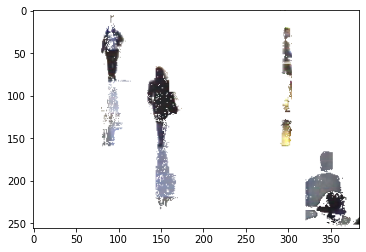

In [10]:
plt.imshow(np.uint8(back_less_img_sharpened))

In [21]:
"""stepSize = 25
(w_width, w_height) = (50, 50) 
image=np.uint8(back_less_img_sharpened)
tmp=image.copy()
for x in range(0, image.shape[1] , stepSize):
    for y in range(0, image.shape[0], stepSize):
        window = image[x:x + w_width, y:y + w_height, :]
        #try:
         #   _, thresholded = cv2.threshold(cv2.cvtColor(window, cv2.COLOR_BGR2GRAY), 2, 255, cv2.THRESH_BINARY)
        #except:
        #    continue
        #non_zero_pixels = cv2.countNonZero(thresholded)
        #if non_zero_pixels >50:
        cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 1) 
"""

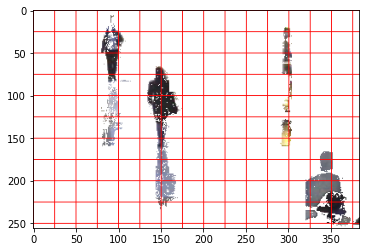

In [22]:
#plt.imshow(np.array(tmp).astype('uint8'))

In [46]:
#mask_bb=SegmentationSharpeningMaskBoundingBox(back_less_img_sharpened)

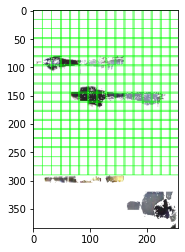

In [53]:
#plt.imshow(np.uint8(cv2.transpose(mask_bb)),cmap="gray")

In [39]:
#print(back_less_img_sharpened.shape[0])

256
